

A lot of code is taken from <a href="https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html"> PyTorch tutorial on Finetuning </a>

Parameters are coming from raytune.

In [1]:
## Imports
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import numpy as np
from pathlib import Path
import os
from facet_ml.classification import mask_rcnn
import matplotlib.pyplot as plt

In [2]:

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotation(90))
        # transforms.append(T.RandomResizedCrop(size=256, scale=(0.6, 1.4)))
        transforms.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1))
        # transforms.append(T.RandomCrop(size=(224, 224)))


    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [3]:
## Load Data ##

device = "cuda"
# Coco folder
coco_dir = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Coco_v5"
coco_dir_train = str( Path(coco_dir) / "train" )
coco_dir_test = str( Path(coco_dir) / "test" )

cd_train = mask_rcnn.ManualCocoColloidalDataset(coco_dir_train, 
                                             str(Path(coco_dir_train) / "_annotations.coco.json"),
                                             transforms=get_transform(True)
                                             )
cd_test = mask_rcnn.ManualCocoColloidalDataset(coco_dir_test, 
                                            str(Path(coco_dir_test) / "_annotations.coco.json"),
                                            transforms=get_transform(False)
                                            )

def collate_fn(batch):
    '''
    Collation function receives [(image_1, targets_1{masks,boxes,labels}), (image_10, targets_1{masks,boxes,labels})...]
    Need to stack image_1
    '''
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # return tuple(zip(*batch))
    return images,targets

dataloader_train = DataLoader(
    cd_train,
    batch_size=2,
    num_workers=0,
    collate_fn=collate_fn
)
dataloader_test = DataLoader(
    cd_test,
    batch_size=2,
    num_workers=0,
    collate_fn=collate_fn
)

In [4]:
# get the model using our helper function
num_classes=2
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.5 # .0005 starting
)
optimizer = torch.optim.Adam(
    params,
    lr=0.000165,
    betas=[0.5, 0.999],
    weight_decay=0.000618,

)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.6
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma = .512368
)

# For testing, train it just for 10 epochs. Otherwise, 100
num_epochs = 10

metric_loggers = []
total_losses = []
from engine import train_one_epoch,evaluate

def validate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass (get the model's predictions)
            outputs = model(images)
            
            # Calculate loss (same loss used in training, if applicable)
            loss_dict = model(images, targets)
            print(loss_dict)
            print(loss_dict[0].keys())
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            
            all_predictions.append(outputs)

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, all_predictions

for epoch in range(num_epochs):
    # Train epochs
    metric_logger = train_one_epoch(model, optimizer, dataloader_train, device,epoch,print_freq=1)
    # metric_loggers.append( train_one_epoch(model, optimizer, dataloader_train, device,epoch,print_freq=1) )

    lr_scheduler.step()
    

c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\tv_tensors\_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)
c:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Tutorials\Scripts\create_models\instance\engine.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = list(torch.tensor(image).to(device).float() for image in images)


Epoch: [0]  [0/2]  eta: 0:00:24  lr: 0.000165  loss: 8.9250 (8.9250)  loss_classifier: 0.5648 (0.5648)  loss_box_reg: 0.8136 (0.8136)  loss_mask: 3.8327 (3.8327)  loss_objectness: 3.5396 (3.5396)  loss_rpn_box_reg: 0.1744 (0.1744)  time: 12.3943  data: 11.3638  max mem: 3544
Epoch: [0]  [1/2]  eta: 0:00:14  lr: 0.000165  loss: 8.9250 (8.9570)  loss_classifier: 0.5648 (0.5799)  loss_box_reg: 0.6978 (0.7557)  loss_mask: 3.6859 (3.7593)  loss_objectness: 3.5396 (3.6947)  loss_rpn_box_reg: 0.1604 (0.1674)  time: 14.6185  data: 13.7786  max mem: 4521
Epoch: [0] Total time: 0:00:29 (14.6190 s / it)
Epoch: [1]  [0/2]  eta: 0:00:24  lr: 0.000165  loss: 2.8589 (2.8589)  loss_classifier: 0.5128 (0.5128)  loss_box_reg: 0.8031 (0.8031)  loss_mask: 1.1912 (1.1912)  loss_objectness: 0.1949 (0.1949)  loss_rpn_box_reg: 0.1568 (0.1568)  time: 12.1417  data: 11.5707  max mem: 4521
Epoch: [1]  [1/2]  eta: 0:00:13  lr: 0.000165  loss: 2.0550 (2.4569)  loss_classifier: 0.3944 (0.4536)  loss_box_reg: 0.6995

In [5]:
## Target image
image_oi, targets_oi = cd_test[0]

targets_oi = [
    {
        k: v.to(device) if isinstance(v, torch.Tensor) else v
        for k, v in targets_oi.items()
    }
]
model.train()
out = model([ image_oi.to("cuda") ],targets_oi)

In [6]:
model.eval()
out = model([ image_oi.to("cuda") ])

{'boxes': tensor([[ 736.3075,  707.9965,  811.0781,  783.1099],
        [ 881.7307,  431.4904,  944.8152,  480.1819],
        [ 715.8893,  592.6869,  789.3489,  687.6723],
        [ 831.8994,  678.2178,  904.3984,  750.5248],
        [ 895.6550,  499.6322,  974.6429,  563.9677],
        [ 876.4361,  474.6808,  930.1957,  531.6036],
        [  98.1828,  235.1326,  192.9091,  326.0285],
        [ 769.6918,  570.7044,  846.5876,  640.7752],
        [ 844.1943,  470.8054,  885.8823,  524.0445],
        [ 128.3734,  273.3533,  243.3916,  384.2717],
        [ 785.6027,  618.4951,  866.7554,  722.2618],
        [  62.5359,  303.0761,  114.3208,  338.7986],
        [ 627.9717,  521.5519,  678.6516,  573.4542],
        [ 742.4475,  511.2037,  790.3478,  560.8057],
        [ 713.7195,  532.9040,  767.7789,  590.1460],
        [ 633.1027,  502.0573,  789.6289,  590.7886],
        [ 213.3830,  338.2068,  250.3109,  416.0846],
        [ 872.2702,  430.6302,  978.1521,  564.4718],
        [ 706.2885

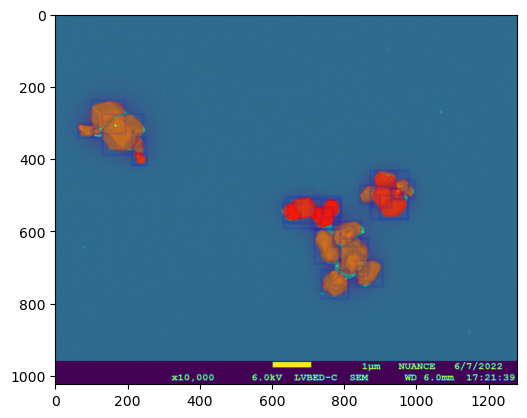

In [7]:
targets = targets_oi[0]
targets = out[0]
print(targets)

masks = targets["masks"]
print("masks:", masks.shape)
boxes = targets["boxes"]
labels = targets["labels"]
scores = targets.get("scores",None)


import matplotlib.patches as patches
from matplotlib.path import Path as plt_Path 
def draw_polygon_with_paths(box,ax):
    # rect = patches.Rectangle( (box[3],box[1]), box[2], box[0],face_color=None)
    vertices = [
        (box[0],box[1]), # Topleft
        (box[0],box[3]), # Bottom Left
        (box[2],box[3]), # Bottom Right
        (box[2],box[1]), # Top Right
        (box[0],box[1])  # Top Left
    ]
    codes = [
        plt_Path.MOVETO,  # Move to the first point (start)
        plt_Path.LINETO,  # Line to the second point
        plt_Path.LINETO,  # Line to the third point
        plt_Path.LINETO,  # Line to the fourth point
        plt_Path.CLOSEPOLY  # Close the path (back to the start)
    ]
    path = plt_Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor='none', edgecolor='blue', linewidth=2,alpha=.1)
    ax.add_patch(patch)

def draw_mask_with_mask(mask,ax):
    from matplotlib.colors import ListedColormap, Normalize
    cmap = ListedColormap(['none', 'red'])
    ax.imshow(mask,cmap=cmap,alpha=.5)

fig, ax = plt.subplots()
ax.imshow(image_oi[0,:,:])

from IPython.display import clear_output
for ii in range(len(masks)):
    if scores is not None:
        
        if scores[ii] < .5:
            continue
    if len(masks[ii].shape) == 3:
        mask = masks[ii][0].to("cpu").detach()
    else:
        mask = masks[ii].to("cpu").detach()
    # mask = masks[ii][0].to("cpu").detach()
    box = boxes[ii].to("cpu").detach()
    label = labels[ii]
    
    draw_polygon_with_paths(box,ax)
    draw_mask_with_mask(mask,ax)
    # print(box)
    # plt.show()
    # from time import sleep
    # sleep(.1)
    # clear_output(wait=True)

plt.show()


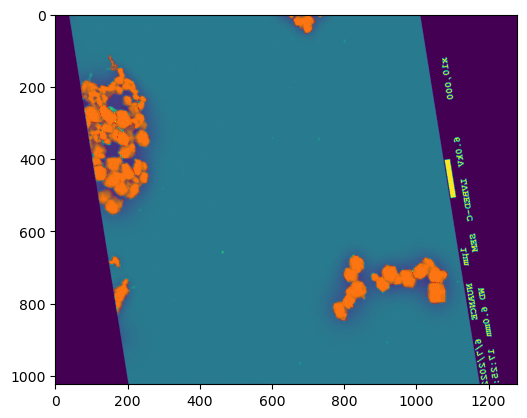

In [12]:
next_item = next(iter(dataloader_train))
img_load, targets_load = (next_item[0][0],next_item[1][0])
fig, ax = plt.subplots()
ax.imshow(img_load[0,:,:])

masks_load = targets_load["masks"]

for ii in range(masks_load.shape[0]):
    mask = masks_load[ii]
    draw_mask_with_mask(mask,ax)
plt.show()

In [13]:
## Check model with completely new image
image_dir = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Additional\L1_2.5_5_10_nM\L1 2.5 nM"
image_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Additional\L1_2.5_5_10_nM\L1 2.5 nM\L1_2.5nM_003.jpg"

import cv2
import glob
img_list = glob.glob( str(Path(image_dir) / "*") )
im = cv2.imread(image_path)
im = cv2.imread(img_list[1])
im_torch = torch.tensor(np.moveaxis(im,-1,0)).to("cuda") / 255
out = model([im_torch])
fig, ax = plt.subplots()
ax.imshow(im[:,:,0])

masks = out[0]["masks"]
boxes = out[0]["boxes"]
scores = out[0]["scores"]

for ii,mask in enumerate(masks):
    score = scores[ii]
    if score < .5:
        continue
    draw_mask_with_mask(mask.to("cpu").detach()[0],ax)
    box = boxes[ii].to("cpu").detach()
    draw_polygon_with_paths(box,ax)

IndexError: list index out of range

In [32]:
len(cd_train.coco["annotations"]) + len(cd_test.coco["annotations"])

384

In [31]:
torch.save(model,"maskrcnn.pth")